This dataset contains solar rooftop potential data (suitable rooftop area, installable capacity, estimated yearly electricity generation, and building type ) at individual building structure level for a sample area of interest in Nairobi. The data was gathered by extracting building rooftop footprint polygons from very high-resolution satellite stereo imagery of 0.5m resolution. The rooftop angle, obstruction, and shading were taken into account during suitable area calculation. The results can be aggregated by different sectors or administrative units for further analysis, which is useful for planning and decision making. Detailed methodology is available upon specific request.

For solar installation companies it is proper to do a feasible study before venturing into solar installation project. In this project, an analysis of the solar rooftop potential data was done. The results obtained from the analysis would be very helpful to a solar comapny.

The objectives of the project were:
1. To determine the number of buildings in the area and the energy potential
  of each house.
2. To determine the types of buildings in the area.
3. To determine how the different building characteristics affect the energy potential.

In [1]:
#Importing the fundamental libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#Library fo encoding categorical variables
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

# Modelling Libraries
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

In [3]:
#Reading in the data
solar = pd.read_csv("nairobi_rooftop_solar_potential.csv")
solar.head()

<ipython-input-3-78ab6c147a5d>:2: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  solar = pd.read_csv("nairobi_rooftop_solar_potential.csv")


,uuid,City,Surface_area,Potential_installable_area,Peak_installable_capacity,Energy_potential_per_year,Assumed_building_type,Estimated_tilt,Estimated_building_height,Estimated_capacity_factor,Unit_installation_price,Comment
0,87100c54-0648-4e73-97f0-3a346c068231,Nairobi,204.53,77.27,14.99,21720.76,single family residential,14.11,9.09,1449.00,NaN,NaN
1,b79fedd1-7c84-4b3f-8fd4-941f3ee17b02,Nairobi,1113.35,676.13,131.17,182191.10,single family residential,21.81,5.57,1388.98,NaN,NaN
2,50ece267-f41a-4bb7-8874-3bf61a9d4aec,Nairobi,577.24,412.30,79.99,115637.95,single family residential,16.34,5.78,1445.72,NaN,NaN
3,df402f1c-5120-4a2f-bb8f-c72c89666c6f,Nairobi,28.58,14.17,2.75,3723.02,single family residential,23.71,4.04,1354.60,NaN,NaN
4,c4d03ac6-80ed-4aa5-95c3-a730c1bf8e68,Nairobi,19.03,6.19,1.20,1655.39,single family residential,22.91,5.31,1378.00,NaN,NaN


# Understanding the Data

In [4]:
#Data info
solar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 272751 entries, 0 to 272750
Data columns (total 12 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   uuid                        272751 non-null  object 
 1   City                        272751 non-null  object 
 2   Surface_area                272751 non-null  float64
 3   Potential_installable_area  272751 non-null  float64
 4   Peak_installable_capacity   272751 non-null  float64
 5   Energy_potential_per_year   272751 non-null  float64
 6   Assumed_building_type       272751 non-null  object 
 7   Estimated_tilt              272751 non-null  float64
 8   Estimated_building_height   272721 non-null  float64
 9   Estimated_capacity_factor   269249 non-null  float64
 10  Unit_installation_price     0 non-null       float64
 11  Comment                     2 non-null       object 
dtypes: float64(8), object(4)
memory usage: 25.0+ MB


The "Unit_installation_price" column do not have any values. The "comment" column has only 2 non-null values. It would therefore be wise to drop the columns

In [5]:
solar_2 = solar.drop(columns = ['Unit_installation_price', 'Comment'], axis = 1)
solar_2.columns

Index(['uuid', 'City', 'Surface_area', 'Potential_installable_area',
       'Peak_installable_capacity', 'Energy_potential_per_year',
       'Assumed_building_type', 'Estimated_tilt', 'Estimated_building_height',
       'Estimated_capacity_factor'],
      dtype='object')

The data has 10 columns after dropping the columns with most empty values.

In [6]:
solar_2.shape

(272751, 10)

## 1. Data Cleaning

The data has 272751 rows representing the number of houses/buildings and 10 columns representing the features of the buildings.


In [7]:
#Checking for missing values
solar_2.isna().sum()

uuid                             0
City                             0
Surface_area                     0
Potential_installable_area       0
Peak_installable_capacity        0
Energy_potential_per_year        0
Assumed_building_type            0
Estimated_tilt                   0
Estimated_building_height       30
Estimated_capacity_factor     3502
dtype: int64

### 1.1. Imputing missing values

In [8]:
#Imputing the missing columns using the mode
solar_2['Estimated_building_height'].fillna(solar_2['Estimated_building_height'].mode()[0], inplace = True)

solar_2['Estimated_capacity_factor'].fillna(solar_2['Estimated_capacity_factor'].mode()[0], inplace = True)

In [9]:
solar_2.isnull().sum()

uuid                          0
City                          0
Surface_area                  0
Potential_installable_area    0
Peak_installable_capacity     0
Energy_potential_per_year     0
Assumed_building_type         0
Estimated_tilt                0
Estimated_building_height     0
Estimated_capacity_factor     0
dtype: int64

Text(0.5, 1.0, 'The distribution of the missing data')

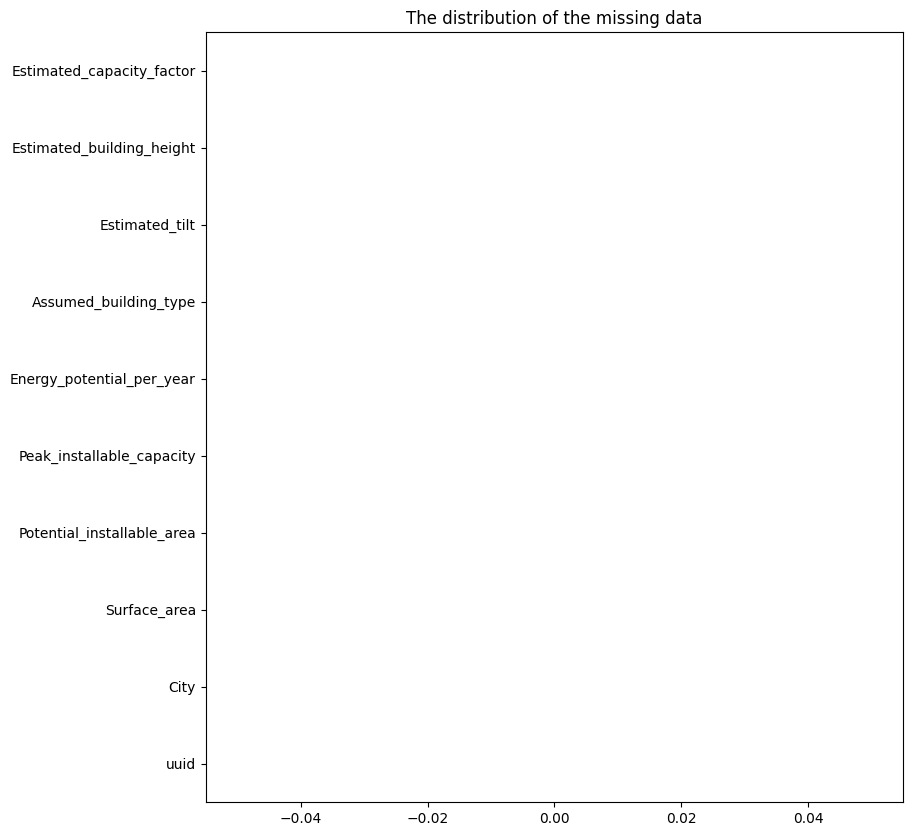

In [10]:
#Plotting a bar graph to see the distribution of the missing data
solar_2.isna().sum().sort_values().plot(kind = 'barh', figsize = (9,10))
plt.title("The distribution of the missing data")

No more missing values

### 1.2. Identifying Categorical Features

In [11]:
solar_2.nunique()

uuid                          272751
City                               1
Surface_area                   48703
Potential_installable_area     35194
Peak_installable_capacity      12787
Energy_potential_per_year     259851
Assumed_building_type              6
Estimated_tilt                  3061
Estimated_building_height       4910
Estimated_capacity_factor      14371
dtype: int64

It can be inferred that there are two columns with categorical variables; City and Assumed_building_type

In [12]:
"""
sns.pairplot(solar_2)
"""

'\nsns.pairplot(solar_2)\n'

# 2. Exploratory Data Analysis

## **2.1. Distribution of building types**

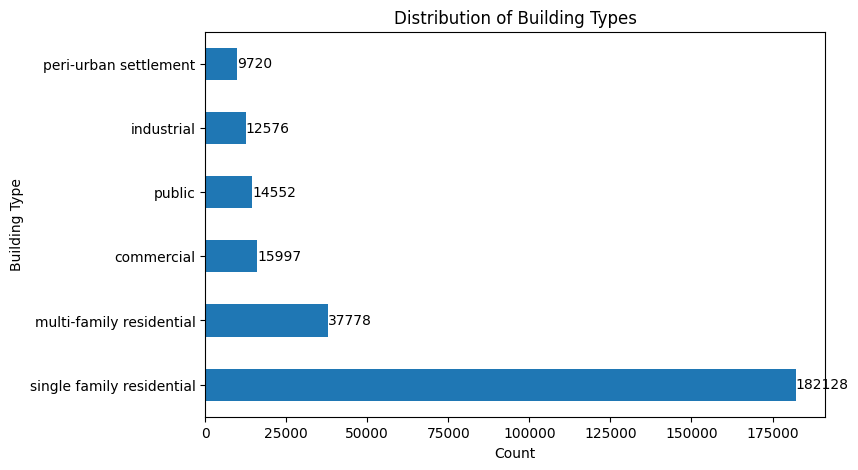

In [13]:
building_type_counts = solar_2["Assumed_building_type"].value_counts()

# Visualization
plt.figure(figsize=(8, 5))
# Plot horizontal bar plot
building_type_counts.plot(kind='barh')
# Annotate each bar with its count
for index, value in enumerate(building_type_counts):
    plt.text(value, index, str(value), ha='left', va='center')
plt.xlabel('Count')
plt.ylabel('Building Type')
plt.title('Distribution of Building Types')
plt.show()


In [14]:
solar_2['Assumed_building_type'].value_counts()

Assumed_building_type
single family residential    182128
multi-family residential      37778
commercial                    15997
public                        14552
industrial                    12576
peri-urban settlement          9720
Name: count, dtype: int64

Most buildings in this area of interest are single family residential, followed by multi-family residential. Industrial and peri-urban settlement buildings are the least. It could be that the area is located in the outskirts of Nairobi

The target variable in the dataset is the energy potential per year. This is because it is the yardstick with which to measure the returns on investment in solar investment.

## **2.2. Relationship between the Energy Potential and the Surface Area**

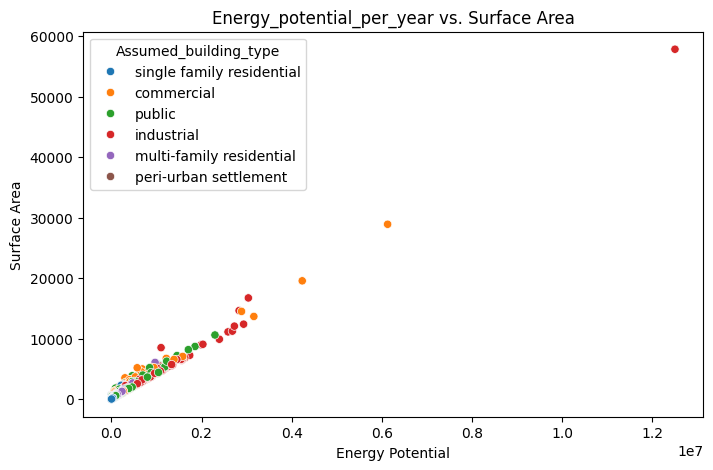

In [15]:
plt.figure(figsize = (8,5))
sns.scatterplot(data = solar_2, x = 'Energy_potential_per_year', y = 'Surface_area', hue = 'Assumed_building_type' )
plt.title("Energy_potential_per_year vs. Surface Area")
plt.xlabel("Energy Potential")
plt.ylabel("Surface Area")
plt.show()

The energy potential per year is directly proportional to the surface area. Therefore any variation of any variable with surface area reflects its variation with energy potential.

## **2.3. Relationship between assumed building type and the estimated building height**

Text(0, 0.5, 'Building Height')

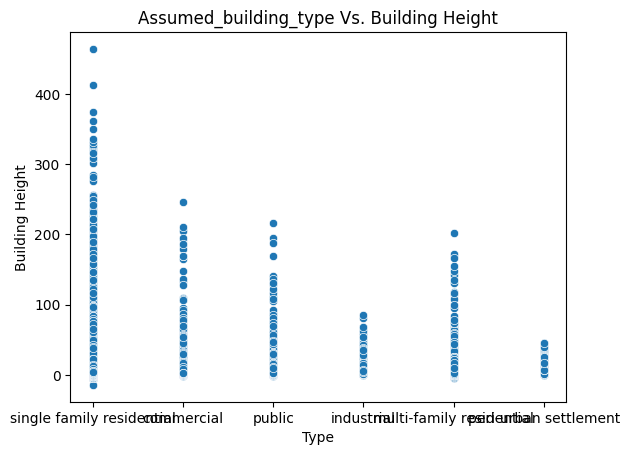

In [16]:

sns.scatterplot(data = solar_2, x = 'Assumed_building_type', y = 'Estimated_building_height')
plt.title("Assumed_building_type Vs. Building Height")
plt.xlabel("Type")
plt.ylabel("Building Height")

## **2.4. Relationship between the building estimated tilt and the estimated building height**

Text(0, 0.5, 'Building Height')

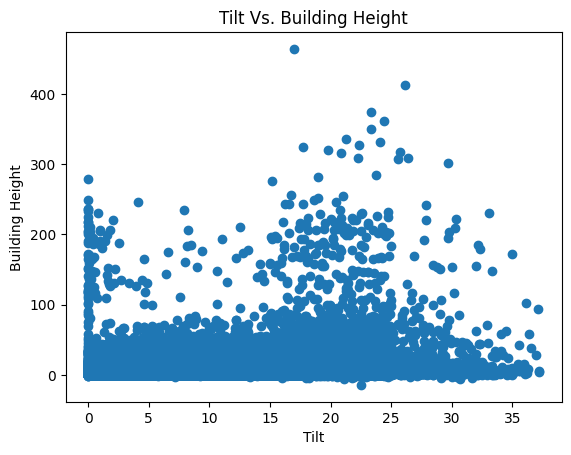

In [17]:
a = solar_2['Estimated_tilt']
b = solar_2['Estimated_building_height']
plt.scatter(a, b)
plt.title("Tilt Vs. Building Height")
plt.xlabel("Tilt")
plt.ylabel("Building Height")

Most buildings have tilts of less than 25 and heights of below 100.

## **2.5. Relationship between the estimated tilt and the surface area**

Text(0, 0.5, 'Surface Area')

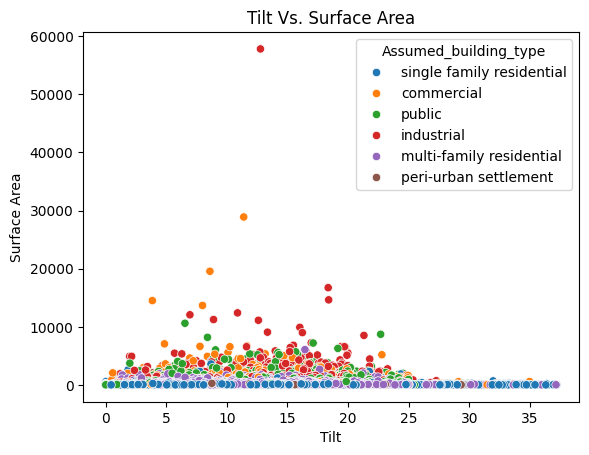

In [18]:

sns.scatterplot(data=solar_2,x='Estimated_tilt', y='Surface_area', hue='Assumed_building_type')
plt.title("Tilt Vs. Surface Area")
plt.xlabel("Tilt")
plt.ylabel("Surface Area")

Houses with a tilt of 25 and above have small surface areas. This translates to low energy potentials.

## **2.6. Relationship between the estimated tilt and the assumed building type**

Text(0, 0.5, 'Building Type')

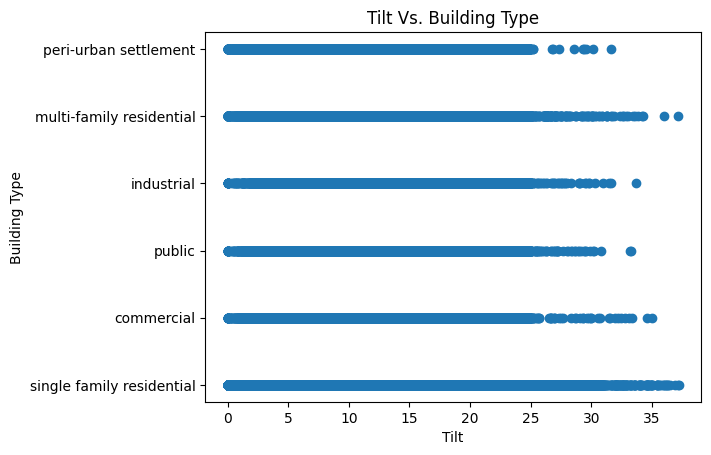

In [19]:
a = solar_2['Estimated_tilt']
b = solar_2['Assumed_building_type']
plt.scatter(a, b)
plt.title("Tilt Vs. Building Type")
plt.xlabel("Tilt")
plt.ylabel("Building Type")

Commercial and public building have tall heights. Surprisingly, they still have high energy potentials. this is beacause these buildings have less buildings with tilt above 25.

### **Buildings with tilt above 25**

In [20]:
results = []

# Loop over each building type category
for building_type in solar_2['Assumed_building_type'].unique():
    # Filter the dataset for buildings of the current type with height > 100m
    filtered_buildings = solar_2[(solar_2['Assumed_building_type'] == building_type) & (solar_2['Estimated_tilt'] > 25)]
    # Count the number of buildings for the current type
    num_buildings = len(filtered_buildings)
    # Append the result to the list
    results.append((building_type, num_buildings))

# Print the results
for building_type, num_buildings in results:
    print(f"Number of {building_type}  with estimated tilt > 25:", num_buildings)

Number of single family residential  with estimated tilt > 25: 676
Number of commercial  with estimated tilt > 25: 43
Number of public  with estimated tilt > 25: 46
Number of industrial  with estimated tilt > 25: 42
Number of multi-family residential  with estimated tilt > 25: 131
Number of peri-urban settlement  with estimated tilt > 25: 12


## **2.7. Relationship between the estimated building height**

Text(0, 0.5, 'Surface_area')

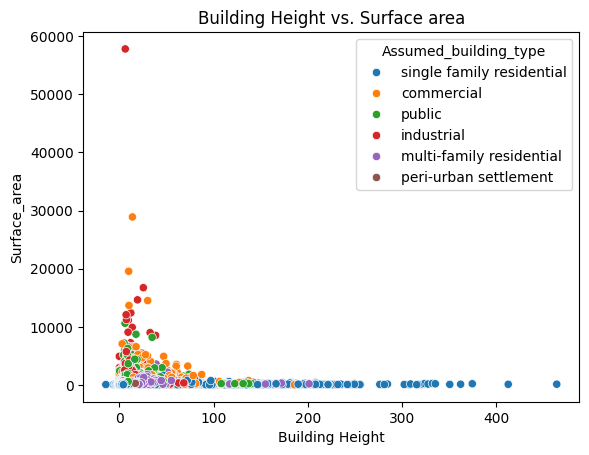

In [21]:
sns.scatterplot(data=solar_2, x='Estimated_building_height', y='Surface_area', hue='Assumed_building_type')
plt.title("Building Height vs. Surface area")
plt.xlabel("Building Height")
plt.ylabel("Surface_area")

Buildings with heights above 100m have small surface areas, translating to low energy potentials.

## **2.9. Relationship between Capacity Factor Vs. Surface Area**

Text(0, 0.5, 'Surface Area')

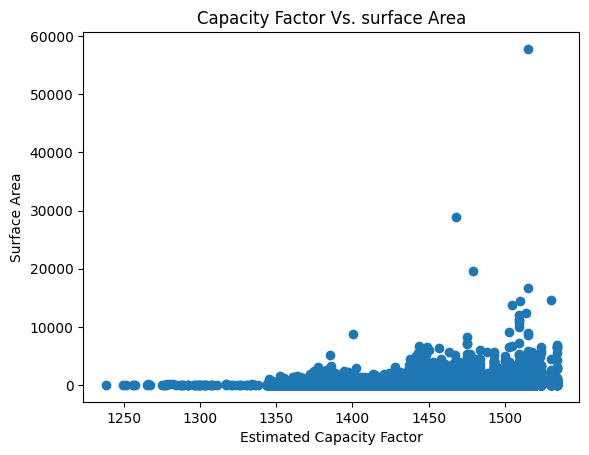

In [22]:
a = solar_2['Estimated_capacity_factor']
b = solar_2['Surface_area']
plt.scatter(a, b)
plt.title("Capacity Factor Vs. surface Area")
plt.xlabel("Estimated Capacity Factor")
plt.ylabel("Surface Area")

Higher capacity factors (above 1350) mean are associated with higher surface areas.

## **2.10 Relationship Between Capacity Factor and Energy Potential**

Text(0, 0.5, 'Energy Potential Per Year')

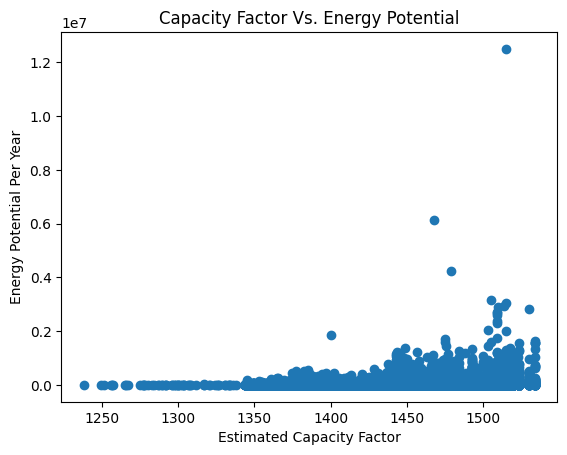

In [23]:
c = solar_2['Estimated_capacity_factor']
d = solar_2['Energy_potential_per_year']
plt.scatter(c, d)
plt.title("Capacity Factor Vs. Energy Potential")
plt.xlabel("Estimated Capacity Factor")
plt.ylabel("Energy Potential Per Year")

Buildings with capacity factor of above 1400 have high energy potentials but the relationship is not linear.

## **2.11. Relationship Between Building Types and Energy Potential**

Text(0, 0.5, 'Energy Potential Per Year')

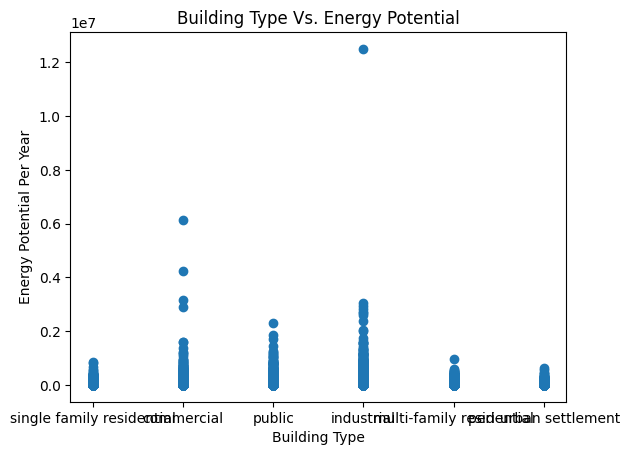

In [24]:
c = solar_2['Assumed_building_type']
d = solar_2['Energy_potential_per_year']
plt.scatter(c, d)
plt.title("Building Type Vs. Energy Potential")
plt.xlabel("Building Type")
plt.ylabel("Energy Potential Per Year")

Most building types have estimated energy potentials below 1 million units per year. Single family residentials, multi-family residentials and urban settlement have the lowest while commercial, public and industrial buildings have multiple buildings with over 1 million units.

In [25]:
solar_2.groupby(['Assumed_building_type']).uuid.count()

Assumed_building_type
commercial                    15997
industrial                    12576
multi-family residential      37778
peri-urban settlement          9720
public                        14552
single family residential    182128
Name: uuid, dtype: int64

### **Buildings with Energy potentials above 900000**

In [26]:
results = []

# Loop over each building type category
for building_type in solar_2['Assumed_building_type'].unique():
    # Filter the dataset for buildings of the current type with height > 100m
    filtered_buildings = solar_2[(solar_2['Assumed_building_type'] == building_type) & (solar_2['Energy_potential_per_year'] > 900000)]
    # Count the number of buildings for the current type
    num_buildings = len(filtered_buildings)
    # Append the result to the list
    results.append((building_type, num_buildings))

# Print the results
for building_type, num_buildings in results:
    print(f"Number of {building_type}  with energy potential > 900000:", num_buildings)

Number of single family residential  with energy potential > 900000: 0
Number of commercial  with energy potential > 900000: 14
Number of public  with energy potential > 900000: 14
Number of industrial  with energy potential > 900000: 50
Number of multi-family residential  with energy potential > 900000: 1
Number of peri-urban settlement  with energy potential > 900000: 0


### **Buildings with height above 100m**

In [27]:
# Filter the dataset for residential buildings with height > 100m
residential_buildings = solar_2[(solar_2['Assumed_building_type'] == 'single family residential') & (solar_2['Estimated_building_height'] > 100)]

# Count the number of residential buildings
num_residential_buildings = len(residential_buildings)

print("Number of residential buildings with height > 100m:", num_residential_buildings)


Number of residential buildings with height > 100m: 256


In [28]:
results = []

# Loop over each building type category
for building_type in solar_2['Assumed_building_type'].unique():
    # Filter the dataset for buildings of the current type with height > 100m
    filtered_buildings = solar_2[(solar_2['Assumed_building_type'] == building_type) & (solar_2['Estimated_building_height'] > 100)]
    # Count the number of buildings for the current type
    num_buildings = len(filtered_buildings)
    # Append the result to the list
    results.append((building_type, num_buildings))

# Print the results
for building_type, num_buildings in results:
    print(f"Number of {building_type} buildings with height > 100m:", num_buildings)




Number of single family residential buildings with height > 100m: 256
Number of commercial buildings with height > 100m: 21
Number of public buildings with height > 100m: 16
Number of industrial buildings with height > 100m: 0
Number of multi-family residential buildings with height > 100m: 14
Number of peri-urban settlement buildings with height > 100m: 0


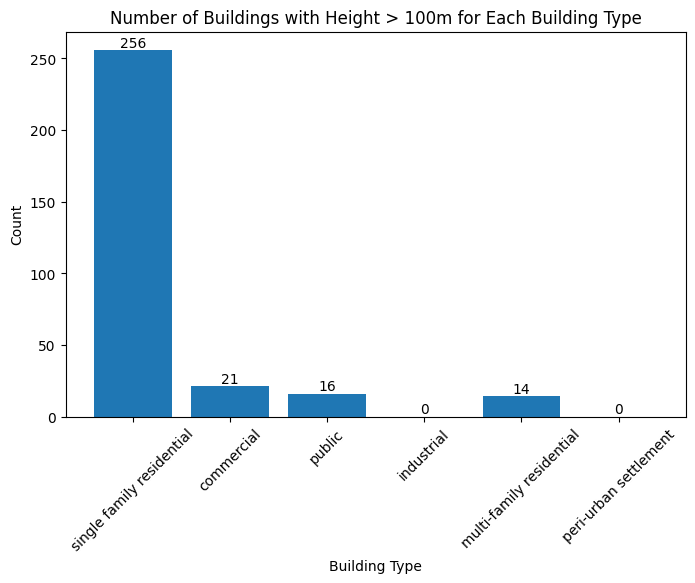

In [29]:
results = []

# Loop over each building type category
for building_type in solar_2['Assumed_building_type'].unique():
    # Filter the dataset for buildings of the current type with height > 100m
    filtered_buildings = solar_2[(solar_2['Assumed_building_type'] == building_type) & (solar_2['Estimated_building_height'] > 100)]
    # Count the number of buildings for the current type
    num_buildings = len(filtered_buildings)
    # Append the result to the list
    results.append((building_type, num_buildings))

# Create a DataFrame from the results
results_df = pd.DataFrame(results, columns=['Building Type', 'Count'])

# Visualization
plt.figure(figsize=(8, 5))
bars = plt.bar(results_df['Building Type'], results_df['Count'])

# Add annotations
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, height, ha='center', va='bottom')

plt.xlabel('Building Type')
plt.ylabel('Count')
plt.title('Number of Buildings with Height > 100m for Each Building Type')
plt.xticks(rotation=45)
plt.show()


# Data Preprocessing

## Feature Encoding

In [30]:
solar_2['Building_type'] = le.fit_transform(solar_2.Assumed_building_type)
solar_2.head()

,uuid,City,Surface_area,Potential_installable_area,Peak_installable_capacity,Energy_potential_per_year,Assumed_building_type,Estimated_tilt,Estimated_building_height,Estimated_capacity_factor,Building_type
0,87100c54-0648-4e73-97f0-3a346c068231,Nairobi,204.53,77.27,14.99,21720.76,single family residential,14.11,9.09,1449.00,5
1,b79fedd1-7c84-4b3f-8fd4-941f3ee17b02,Nairobi,1113.35,676.13,131.17,182191.10,single family residential,21.81,5.57,1388.98,5
2,50ece267-f41a-4bb7-8874-3bf61a9d4aec,Nairobi,577.24,412.30,79.99,115637.95,single family residential,16.34,5.78,1445.72,5
3,df402f1c-5120-4a2f-bb8f-c72c89666c6f,Nairobi,28.58,14.17,2.75,3723.02,single family residential,23.71,4.04,1354.60,5
4,c4d03ac6-80ed-4aa5-95c3-a730c1bf8e68,Nairobi,19.03,6.19,1.20,1655.39,single family residential,22.91,5.31,1378.00,5


In [31]:
solar_3 = solar_2.drop(columns = ['uuid', 'City', 'Assumed_building_type'], axis =1)
solar_3.head()

,Surface_area,Potential_installable_area,Peak_installable_capacity,Energy_potential_per_year,Estimated_tilt,Estimated_building_height,Estimated_capacity_factor,Building_type
0,204.53,77.27,14.99,21720.76,14.11,9.09,1449.00,5
1,1113.35,676.13,131.17,182191.10,21.81,5.57,1388.98,5
2,577.24,412.30,79.99,115637.95,16.34,5.78,1445.72,5
3,28.58,14.17,2.75,3723.02,23.71,4.04,1354.60,5
4,19.03,6.19,1.20,1655.39,22.91,5.31,1378.00,5


In [32]:
solar_3.columns

Index(['Surface_area', 'Potential_installable_area',
       'Peak_installable_capacity', 'Energy_potential_per_year',
       'Estimated_tilt', 'Estimated_building_height',
       'Estimated_capacity_factor', 'Building_type'],
      dtype='object')

## Feature Correlation

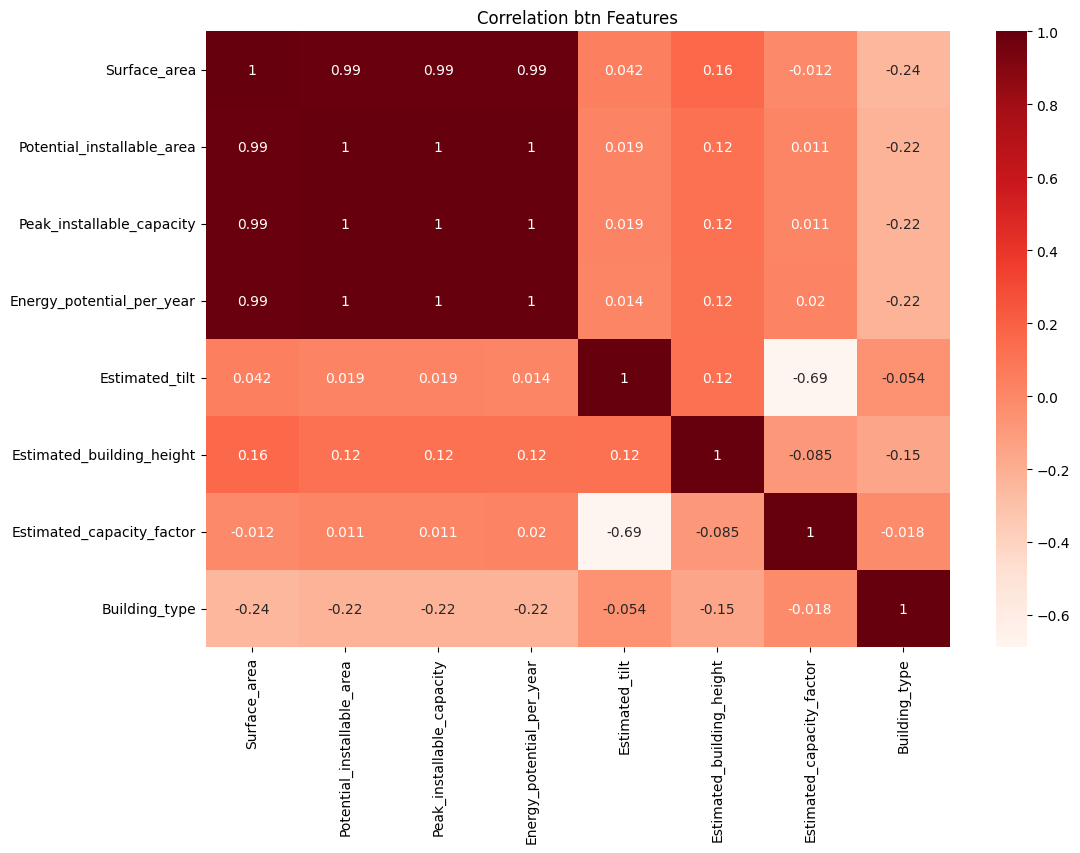

In [33]:
#Correlation of the features
plt.figure(figsize = (12,8))
sns.heatmap(solar_3.corr(), annot = True, cmap = plt.cm.Reds)
plt.title('Correlation btn Features')
plt.show()

The potential installable area, peak installable capacity and surface area have high correlations. All of then will be dropped except the surface area.

In [34]:
solar_4 = solar_3.drop(columns = ['Potential_installable_area', 'Peak_installable_capacity'], axis = 1)

In [35]:
#Splitting the data
x = solar_4.drop(columns = ['Energy_potential_per_year'], axis = 1)
y = solar_4['Energy_potential_per_year']

In [36]:
x.columns

Index(['Surface_area', 'Estimated_tilt', 'Estimated_building_height',
       'Estimated_capacity_factor', 'Building_type'],
      dtype='object')

In [37]:
solar_4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 272751 entries, 0 to 272750
Data columns (total 6 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Surface_area               272751 non-null  float64
 1   Energy_potential_per_year  272751 non-null  float64
 2   Estimated_tilt             272751 non-null  float64
 3   Estimated_building_height  272751 non-null  float64
 4   Estimated_capacity_factor  272751 non-null  float64
 5   Building_type              272751 non-null  int64  
dtypes: float64(5), int64(1)
memory usage: 12.5 MB


## Train/Test Split

In [38]:
X_train, X_temp, y_train, y_temp = train_test_split(x,
                                                    y,
                                                    train_size=0.8,
                                                    random_state=7)

X_val, X_test, y_val, y_test = train_test_split(X_temp,
                                                y_temp,
                                                train_size=0.5,
                                                random_state=7)

## Modelling

In [39]:
# Modelling Libraries
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

In [40]:
# Instantiate models
linear_regression = LinearRegression()
decision_tree = DecisionTreeRegressor()
random_forest = RandomForestRegressor()
gradient_boosting = GradientBoostingRegressor()
xgb = XGBRegressor()

models = [linear_regression, decision_tree, random_forest, gradient_boosting, xgb]

## Model Training and Evaluation

In [41]:
for model in models:
  # Fit our model
  model.fit(X_train, y_train)

  # Evaluate model
  predictions = model.predict(X_val)
  mae = metrics.mean_absolute_error(y_val, predictions)
  rmse = metrics.mean_squared_error(y_val, predictions, squared=False)
  print(f'The {model} model has a mean absolute error of {mae}, and a root mean squared error of {rmse}')


The LinearRegression() model has a mean absolute error of 4058.858073360693, and a root mean squared error of 8203.701720514755
The DecisionTreeRegressor() model has a mean absolute error of 3588.690399633364, and a root mean squared error of 8205.824495931358
The RandomForestRegressor() model has a mean absolute error of 2696.6424430027496, and a root mean squared error of 6254.342229862532
The GradientBoostingRegressor() model has a mean absolute error of 2708.6160869346754, and a root mean squared error of 6055.263089855691
The XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to

Linear Regression and and Random Forest models are the best performing models on training data. They are then tested on test data.

In [42]:
My_test_models = [linear_regression, random_forest]

In [43]:
for model in My_test_models:
  predictions = model.predict(X_test)
  mae = metrics.mean_absolute_error(y_test, predictions)
  rmse = metrics.mean_squared_error(y_test, predictions, squared=False)
  print(f'The {model} model has a mean absolute error of {mae} and a root mean squared error of {rmse}')

The LinearRegression() model has a mean absolute error of 4074.431759810112 and a root mean squared error of 9734.857023557455
The RandomForestRegressor() model has a mean absolute error of 2702.607767066285 and a root mean squared error of 7984.269486052048


Random Forest Regressor performs better than LinearRegression on both training and test data. It is therefore used in predicting unseen data and utilized in this project.

In [44]:
solar_4.head(50)

,Surface_area,Energy_potential_per_year,Estimated_tilt,Estimated_building_height,Estimated_capacity_factor,Building_type
0,204.53,21720.76,14.11,9.09,1449.00,5
1,1113.35,182191.10,21.81,5.57,1388.98,5
2,577.24,115637.95,16.34,5.78,1445.72,5
3,28.58,3723.02,23.71,4.04,1354.60,5
4,19.03,1655.39,22.91,5.31,1378.00,5
5,237.14,27758.43,15.69,6.17,1456.00,5
6,712.50,140527.11,9.27,13.45,1475.00,0
7,227.37,35520.03,11.37,6.38,1426.69,0
8,26.88,3322.80,20.19,1.49,1414.00,5
9,121.90,19360.76,19.77,1.77,1449.39,5


In [45]:
one_instance = [[204.00, 14, 14, 1450.7, 5]]
predict_this = random_forest.predict(one_instance)
predict_this

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


array([26945.579])

## Model Serialization

In [46]:
import pickle

pickle_out = open("solar_potential_estimate.pkl", "wb")
pickle.dump(random_forest, pickle_out)
pickle_out.close()